In [599]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from my_functions import *
from p_parts import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading the image and thresholding

In [600]:
def BGR2GRAY(img):
    if (img.ndim==3):
        out=0.3*img[...,2]+0.59*img[...,1]+0.11*img[...,0]
    else:
        out=img[...,0]
        print("Invalid Dimension")
    return out

141.0


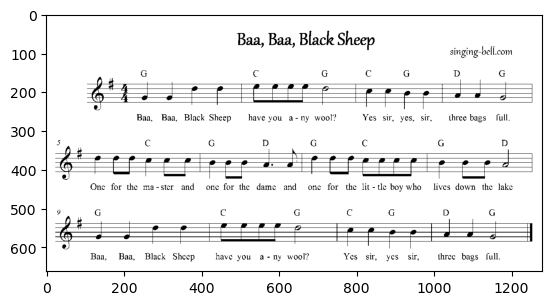

In [637]:
img_notes=cv2.imread("../data/inputs/notes3.jpeg",cv2.IMREAD_GRAYSCALE)
# print(img_t)
ret,img_th=cv2.threshold(img_notes,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# plt.imshow(th_img)

## TO ROTATE IMAGE, UNCOMMENT THIS
# img_th=correctSkew(img_th)
print(ret)
plt.imshow(img_th,cmap="gray")

## Preprocessing

In [638]:
def make_disc(size,bg=0):
    size=int(size)
    if(size%2==0):
        size+=1
    K=np.ones((size,size))*bg
    radius=int(size//2)
    u,v=np.meshgrid(np.arange(size),np.arange(size))
    idx=(u-radius)**2+(v-radius)**2<=radius**2
    K[idx]=1
    # plt.imshow(K,cmap='gray')
    return K

In [639]:
def struc_slide(img,kernel,method=0,pad_img=True,round=True,ignore=-1):
    K=kernel.shape[0]
    # pad=(K-1)//2
    fg=img.max()
    img=img.astype('float64')
    out=np.zeros_like(img)
    if fg==0:
        return out
    if kernel.shape[1]%2==1:
        pad_x_min=(kernel.shape[1]-1)//2
        pad_x_max=pad_x_min
    else:
        pad_x_max=(kernel.shape[1])//2
        pad_x_min=pad_x_max-1
    if kernel.shape[0]%2==1:
        pad_y_min=(kernel.shape[0]-1)//2
        pad_y_max=pad_y_min
    else:
        pad_y_max=(kernel.shape[0])//2
        pad_y_min=pad_y_max-1
    #The input is padded with zeros on edges, so output size is same as input
    padding=((pad_y_min,pad_y_max),(pad_x_min,pad_x_max))

    if(pad_img):
        img=np.pad(img,padding)

    idx=kernel!=ignore
    for y in range(pad_y_min,img.shape[0]-pad_y_max):
        for x in range(pad_x_min,img.shape[1]-pad_x_max):
            sub_img=img[y-pad_y_min:y+pad_y_max+1,x-pad_x_min:x+pad_x_max+1]//fg
            prod=np.zeros_like(kernel)
            
            prod[idx]=(sub_img[idx]==kernel[idx])
            if method==0:
                out[y-pad_y_min,x-pad_x_min]=fg*((prod[idx]).sum()==(len(kernel[idx]))).astype('int')
            else:
                out[y-pad_y_min,x-pad_x_min]=fg*(prod[idx].sum()>0).astype('int')
    return out if not round else np.round(out)

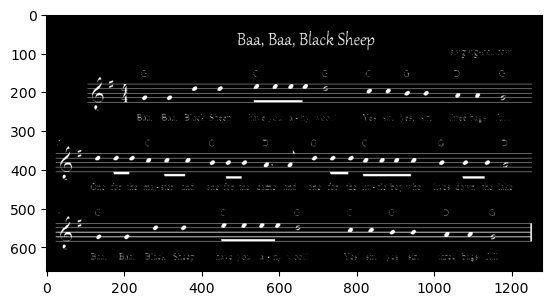

In [640]:
kernel=np.ones((3,3))*-1
kernel[1,:]=1
img_th_inv=(255-img_th)
# plt.imshow(img_th_inv,cmap='gray')
# cv2.imwrite("bin_img.png",img_th_inv)
eroded_img=struc_slide(img_th_inv,kernel)
plt.imshow(eroded_img,cmap='gray')

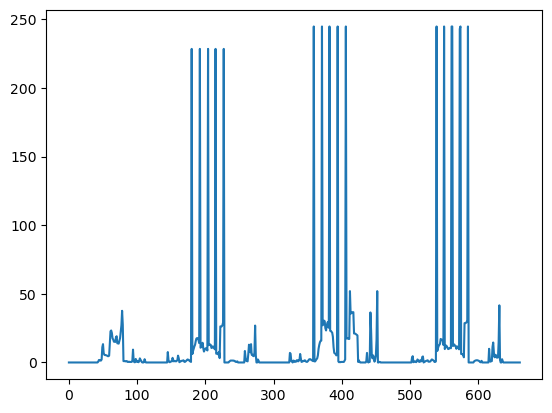

In [641]:
col_sum=eroded_img.sum(axis=1)/img_th_inv.shape[1]
plt.plot(col_sum)
# print(row_sum.shape,img_th_inv.shape)

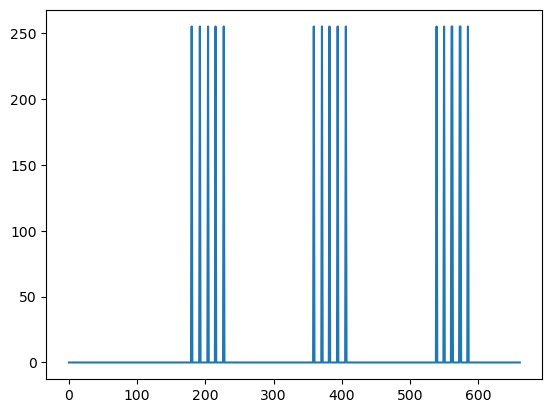

In [642]:
ret_col,img_col_th=cv2.threshold(col_sum.astype("uint8"),0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.plot(img_col_th)

11


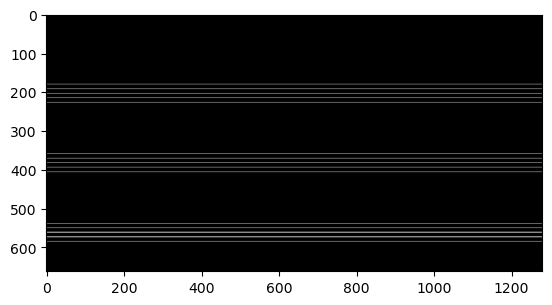

In [643]:
non_zero = np.where(img_col_th!=0)[0]
img_black = np.zeros((img_th_inv.shape))
img_black[non_zero, :] = 255
diff_shaff=np.diff(non_zero)
print(np.median(diff_shaff).astype('int'))
# print(diff_shaff)
shaff_dist=np.median(diff_shaff).astype('int')
plt.imshow(img_black, cmap='gray')
plt.show()

In [644]:
# Eroding with vertical lines of variable lenght

max_diff=0
k_size_opt=0
max_k=img_col_th.shape[0]
img_col_inv=255-img_col_th


In [645]:
def seg_mask(img_col_inv):
    num_peak_lst=[]
    idx_start=3
    max_k=img_col_inv.shape[0]
    for k_size in range(idx_start,max_k):
        k_ver=np.ones((k_size,1))
        eroded_ver=struc_slide(img_col_inv,k_ver)
        img_col_diff=np.abs(np.diff(eroded_ver,axis=0))
        num_peaks=img_col_diff.sum()
        # peak_diff=num_peaks-prev_peaks
        num_peak_lst.append(num_peaks)

    num_peak_arr=np.array(num_peak_lst)
    peak_diff=np.abs(np.diff(num_peak_arr,axis=0))
    k_size_opt=peak_diff.argmax()+2*idx_start
    # print(peak_diff.argmax())
    k_ver=np.ones((k_size_opt,1))
    eroded_ver=struc_slide(img_col_inv,k_ver)
    # plt.plot(num_peak_arr)
    # plt.plot(eroded_ver)
    mask_seg=eroded_ver.reshape(-1)==255
    mask_seg=mask_seg.astype('int')
    return mask_seg

In [646]:
mask_seg=seg_mask(img_col_inv)

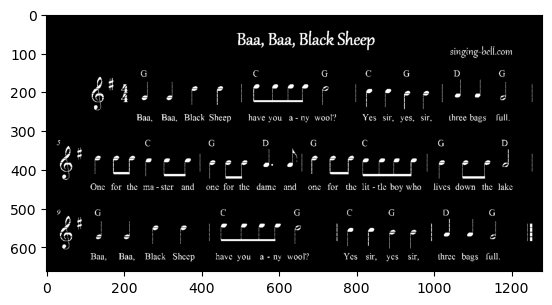

In [647]:
line_mask=img_col_th.reshape(-1)==255
img_th_inv[line_mask,:]=0
plt.imshow(img_th_inv,cmap="gray")

## Label

In [648]:
def label_img(img,shaff_dist):
    kernel=make_disc(shaff_dist//2,bg=0).astype('uint8')
    # dilate=struc_slide(img,kernel,method=1).astype('uint8')
    # dilate=struc_slide(dilate,kernel,method=1).astype('uint8')
    dilate=cv2.morphologyEx(img,cv2.MORPH_DILATE,kernel,iterations=2)
    # closed=struc_slide(dilate,kernel,method=0).astype('uint8')
    # plt.imshow(closed,cmap="gray")
    plt.imshow(dilate,cmap="gray")
    analysis = cv2.connectedComponentsWithStats(dilate,8,cv2.CV_32S)
    (totalLabels, label_ids, values, centroid) = analysis
    return totalLabels,label_ids,values,centroid

## Segmentation

In [649]:
def segment_notes(img_th_inv,mask_seg):
    idx1=-1
    idx2=-1
    # print(mask_seg)
    mask_seg_mid=np.zeros_like(mask_seg)
    # midpoints=[]
    # for i in range(mask_seg.shape[0]-1):
    #     if((i==0 and mask_seg[i]>0) or (mask_seg[i]-mask_seg[i+1]<0)):
    #         idx1=i
    #     elif i+1==mask_seg.shape[0] or  (mask_seg[i]-mask_seg[i+1]>0):
    #         idx2=i
    #     if idx1!=-1 and idx2!=-1:
    #         # print(idx1,idx2)
    #         mask_seg_mid[(idx1+idx2)//2]=1
    #         midpoints.append((idx1+idx2)//2)
    #         idx1=-1
    #         idx2=-1
    pts_o_ch=np.diff(mask_seg.astype('int'))
    # plt.plot((mask_seg))
    pts_pve=np.where(pts_o_ch>0)[0]
    pts_nve=np.where(pts_o_ch<0)[0]
    # print(pts_pve,pts_nve)
    # idx_o_ch=np.where(pts_o_ch==1)[0]
    # print(idx_o_ch)
    if(pts_pve.shape<pts_nve.shape):
        pts_pve=np.resize(pts_nve.shape)
        pts_pve[1:]=pts_pve[0:-1]
        pts_pve[0]=0
    if(pts_pve.shape>pts_nve.shape):
        pts_nve=np.resize(pts_pve.shape)
        # pts_nve[1:]=pts_nve[0:-1]
        pts_nve[-1]=img_th_inv.shape[0]
    # midpoints=(idx_o_ch[0:-1]+idx_o_ch[1:])//2
    midpoints=(pts_pve+pts_nve)//2
    # print(midpoints)
    img_segments=[]
    # orig_img_segments=[]
    # img_segments.append()
    for i in  range(len(midpoints)):
        # if i==0:
        #     tmp_img=img_th_inv[0:midpoints[i]].copy()
        if i==len(midpoints)-1:
            tmp_img=img_th_inv[midpoints[i]:img_th_inv.shape[0]].copy()
            # tmp_img1=(255-img_th)[midpoints[i]:img_th_inv.shape[0]].copy()
        else:
            tmp_img=img_th_inv[midpoints[i]:midpoints[i+1]].copy()
            # tmp_img1=(255-img_th)[midpoints[i]:midpoints[i+1]].copy()
        img_segments.append(tmp_img)
        # orig_img_segments.append(tmp_img1)
    # plt.imshow(img_segments[0],cmap="gray")
    # print(midpoints)
    return img_segments#,orig_img_segments

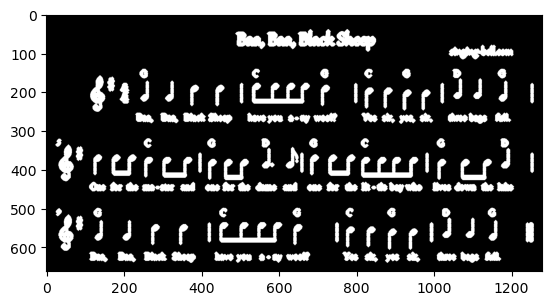

In [650]:
totalLabels,label_ids,values,_=label_img(img_th_inv,shaff_dist)


[  0 255]


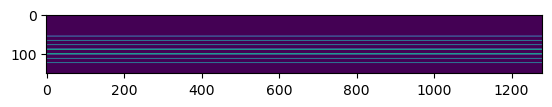

In [651]:
img_segments=segment_notes(img_th_inv,mask_seg)
orig_img_segments=segment_notes(255-img_th,mask_seg)
label_segments=segment_notes(label_ids,mask_seg)
label_segments1=segment_notes(label_ids,mask_seg)
staff_segments=segment_notes(img_black,mask_seg)
staff_segments_e=add_staff(staff_segments,shaff_dist)
plt.imshow(staff_segments_e[2])
print(np.unique(staff_segments_e[2]))
# plt.imshow(img_segments[2],cmap='gray')

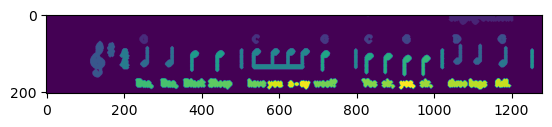

In [652]:
plt.imshow(label_segments[0])
# print(np.unique(label_ids))
# print(totalLabels)

## Clef Detection

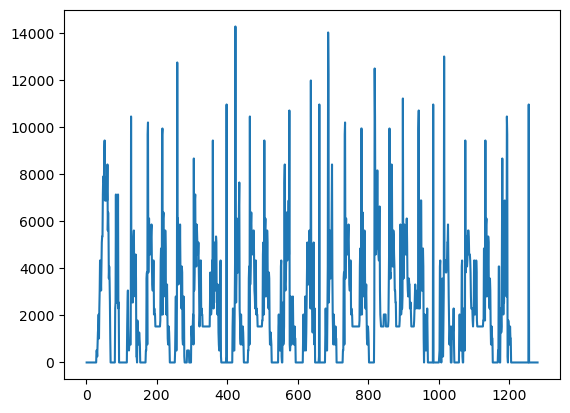

In [653]:
line1 = img_segments[0]
line2 = img_segments[1]
rowsums = np.sum(line2, axis=0)
xaxis = np.arange(1, rowsums.shape[0] + 1)
plt.plot(xaxis, rowsums)
plt.show()

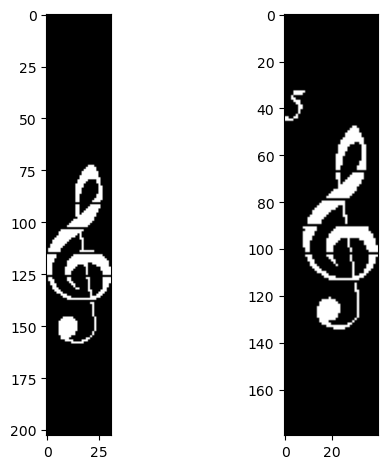

In [654]:
clef_arr_t = getClef(line1, np.sum(line1, axis=0))
clef_arr_b = getClef(line2, np.sum(line2, axis=0))

plt.subplot(1,2,1)
plt.imshow(clef_arr_t, cmap='gray')

plt.subplot(1,2,2)
plt.imshow(clef_arr_b, cmap='gray')

plt.tight_layout()
plt.show()

## Secion 2.2.3 , 2.2.4 and Label

[ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]


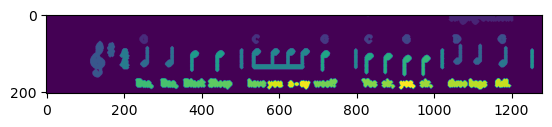

In [655]:
plt.imshow(label_segments[0])
print(np.unique(label_segments[0]))

11
617 3872
615 3872
625 3872
626 3872
3888 3872
642 3872
681 3872
670 3872
640 3872
674 3872
634 3872
874 3872
724 3872
630 3872
1799 3872
666 3872
1882 3872
633 3872
1917 3872
3971 3872
635 3872
1751 3872
635 3872
1978 3872
649 3872
616 3872
606 3872
615 3872
3984 3872
627 3872
639 3872
628 3872
662 3872
637 3872
643 3872


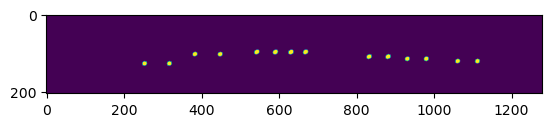

In [656]:
dic_lbl={}
print(shaff_dist)
note_wo=qtr_note_det(orig_img_segments,label_segments,values,shaff_dist,dic_lbl)

[  0 255]


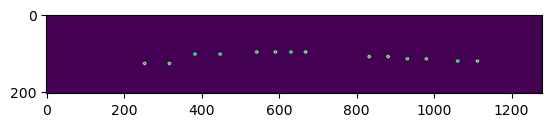

In [657]:
to_plot=np.zeros_like(label_segments[1])
to_plot[label_segments[1]==dic_lbl['e']]=255
plt.imshow(note_wo[0])
print(np.unique(note_wo[0]))

In [658]:
note_wh=half_note_det(img_segments,label_segments,staff_segments_e,note_wo,values,shaff_dist,dic_lbl)

(8960,) 80 149
(69, 1280)
(8960,) 80 149
(69, 1280)
(8960,) 80 149
(69, 1280)
(2,) 0 39
(39, 1280)


{'s': 15, 'q': 22, 'e': -1, 'wh': 19, 'hh': -1}
[  0 255]


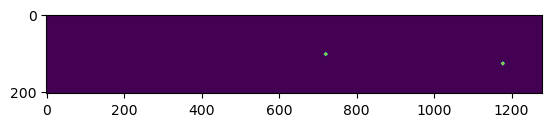

In [659]:
print(dic_lbl)
plt.imshow(note_wh[0])
print(np.unique(note_wo[0]))

{'s': 15, 'q': 22, 'e': -1, 'wh': 19, 'hh': -1}


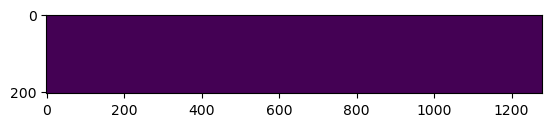

In [660]:
to_plot=np.zeros_like(label_segments[0])
print(dic_lbl)
to_plot[label_segments[0]==dic_lbl['hh']]=255
plt.imshow(to_plot)

In [661]:
from p_parts import make_blob_dic,label_notes,get_dic
blob_dic_list,note_pts_list,blob_dic_dilated_list=make_blob_dic(label_segments,note_wo,note_wh,dic_lbl,shaff_dist//4)
labelled_list=label_notes(note_pts_list)
mega_dic=get_dic(blob_dic_list,labelled_list)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
0
5
7
8
9
10
11
12
13
15
16
0
0
1
2
3
4
0
0
6
14
[ 0 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
0
18
19
20
21
22
23
24
25
26
31
32
33
34
35
36
37
38
0
0
27
28
29
30
0
0
39
[ 0 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55]
0
45
46
47
48
49
50
51
52
53
54
0
0
41
42
43
44
0
0
55
[0]
0
0
0
0
0


In [662]:
print(mega_dic)

{5: 's', 7: 's', 8: 's', 9: 's', 10: 's', 11: 's', 12: 's', 13: 's', 15: 's', 16: 's', 1: 'q', 2: 'q', 3: 'q', 4: 'q', 6: 'wh', 14: 'wh', 18: 's', 19: 's', 20: 's', 21: 's', 22: 's', 23: 's', 24: 's', 25: 's', 26: 's', 31: 's', 32: 's', 33: 's', 34: 's', 35: 's', 36: 's', 37: 's', 38: 's', 27: 'q', 28: 'q', 29: 'q', 30: 'q', 39: 'wh', 45: 's', 46: 's', 47: 's', 48: 's', 49: 's', 50: 's', 51: 's', 52: 's', 53: 's', 54: 's', 41: 'q', 42: 'q', 43: 'q', 44: 'q', 55: 'wh'}


In [663]:
# plt.imshow(labelled_list[2])
print(np.unique(labelled_list[0]))
print(np.unique(labelled_list[2]))
print(np.unique(labelled_list[1]))


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[ 0 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55]
[ 0 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


[[[['g', 2], ['g', 2], ['D', 2], ['D', 2], ['D', 8], ['B', 2], ['B', 2], ['B', 2], ['g', 2], ['g', 8]]]]


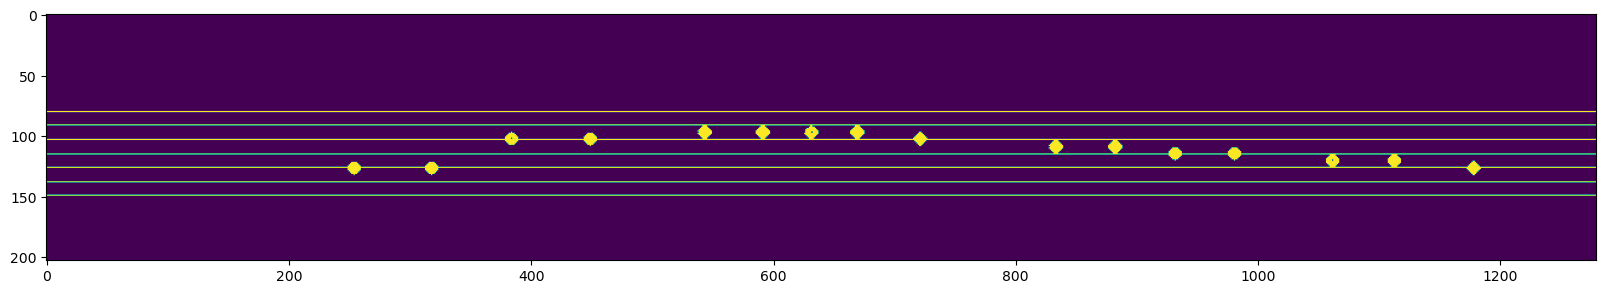

In [664]:
lineMask = staff_segments_e
noStemLabelledNotes = []
for i in range(len(lineMask)):
    # temp = label_segments[i] * noteWithoutStemMask[i]
    # noStemLabelledNotes.append(temp)
    lineMask[i] = LineWidthNorm(lineMask[i])

imgNotes = []
for i in range(len(lineMask)):
    imgNotes.append(getSegmentNotes(lineMask[i], labelled_list[i],mega_dic))

# for i in range(len(imgNotes)):
#     print(imgNotes[i])
#     break
print(imgNotes[0])
# plt.imshow(((labelled_list[0]!=0)+(staff_segments_e[0]!=0))*255)
plt.figure(figsize=[20,20])
plt.imshow(((labelled_list[0]!=0)+(staff_segments_e[0]!=0))*255)
# plt.imshow(blob_dic_list['hh'][0])
# plt.imshow(labelled_list[0])
# plt.imshow(blob_dic_list['e'][0])

In [665]:
appended_notes=[]
for i in range(0,len(imgNotes)):
    for note in imgNotes[i]:
        for note_in in note:
            for note_in_in in note_in:
                # print(note_in_in)
                appended_notes.append(note_in_in)
# print(appended_notes)

In [666]:
from scipy.io.wavfile import write

In [667]:
x = np.array(appended_notes)
music_notes = x.flatten()
print(music_notes)

['g' '2' 'g' '2' 'D' '2' 'D' '2' 'D' '8' 'B' '2' 'B' '2' 'B' '2' 'g' '2'
 'g' '8' 'D' '2' 'D' '2' 'D' '2' 'C' '2' 'D' '2' 'D' '2' 'B' '2' 'B' '2'
 'B' '2' 'D' '2' 'D' '2' 'D' '2' 'B' '2' 'B' '2' 'B' '2' 'g' '2' 'g' '2'
 'D' '2' 'D' '2' 'B' '2' 'B' '2' 'B' '2' 'B' '2' 'g' '8']


In [668]:
#Sampling Rate
samplerate = 44100 

def getWave(freq, timeCount):

    oneCountTime = 0.25

    duration = (float)(timeCount) * oneCountTime
    amplitude = 4096
    t = np.linspace(0, duration, int(samplerate * duration))
    wave = amplitude * np.sin(2 * np.pi * freq * t)
    
    return wave

In [669]:
def getPianoNotes():

    # Returns a dict object for all the piano note's frequencies
    lowerOctaveFreq = []
    highOctaveFreq = []

    lowerOctaveNotes = ['c', 'c$', 'd', 'd$', 'e', 'f', 'f$', 'g', 'g$', 'a','a$', 'b']
    highOctaveNotes = ['C', 'c#', 'D', 'd#', 'E', 'F', 'f#', 'G', 'g#', 'A', 'a#', 'B'] 
    
    base_freq = 261.63 #Frequency of Note C4
    highOctaveFreqMap = {highOctaveNotes[i]: base_freq * pow(2,(i/12)) for i in range(len(highOctaveNotes))}        
    highOctaveFreqMap[''] = 0.0 # silent note


    base_freq = 130.81 #Frequency of Note C4
    lowOctaveFreqMap = {lowerOctaveNotes[i]: base_freq * pow(2,(i/12)) for i in range(len(lowerOctaveNotes))}        
    lowOctaveFreqMap[' '] = 0.0 # silent note


    noteFreq = lowOctaveFreqMap
    noteFreq.update(highOctaveFreqMap)
    
    return noteFreq

In [670]:
note_freqs = getPianoNotes()
print(note_freqs)

{'c': 130.81, 'c$': 138.58836737313942, 'd': 146.8292605393491, 'd$': 155.56018271350595, 'e': 164.81027253674836, 'f': 174.6104013239822, 'f$': 184.99327609402457, 'g': 195.9935487262387, 'g$': 207.64793160796017, 'a': 219.9953201586768, 'a$': 233.07692263987556, 'b': 246.93639768378463, ' ': 0.0, 'C': 261.63, 'c#': 277.18732937722245, 'D': 293.66974569918125, 'd#': 311.1322574981619, 'E': 329.63314428399565, 'F': 349.2341510465061, 'f#': 370.00069432367286, 'G': 392.0020805232462, 'g#': 415.31173722644, 'A': 440.00745824565865, 'a#': 466.1716632541139, 'B': 493.8916728538229, '': 0.0}


In [671]:
def isAlpha(c):
    if((c >= 'a' and c <= 'z') or (c >= 'A' or c <= 'Z')):
        return "TRUE"
    
    return "FALSE"

# Step 1:
    # "c2b1C0" -> "c   b  C"
    # insert spaces based on timeCount
# Step 2:
    # use map to get song

def getSongData(music_notes):
    i = 0
    song = []
    while(i < len(music_notes)):
        currentNote = music_notes[i]
        currentTime = music_notes[i+1]
        currentFreq = note_freqs[currentNote]

        currentNoteSong = getWave(currentFreq, currentTime)
        song = np.append(song,currentNoteSong)

        i = i + 2 

    # SONG = np.array(song)
    return song

In [672]:
Highdata = getSongData(music_notes)
write('../data/outs/Highabcd1.wav', samplerate, Highdata.astype(np.int16))
